# Importing Bitbrain headset data into MNE

**Authors**:

 - Javi Rameerez javi@rameerez.com | [@rameerez [tw]](http://twitter.com/rameerez)

---

_This code is Open Source, released under a GPL License._

In [90]:
import mne
import pandas as pd
import numpy as np

%matplotlib inline

## Loading Bitbrain's .CSV EEG into a Pandas dataframe

Bitbrain's headset records EEG data in `.csv` files. These are easily loadaed into a Pandas dataframe.

First, we'll load a Bitbrain CSV

In [91]:
df = pd.read_csv("../first-experiments/data/3-thinking-about-moving-hands-2-BBT-E16-AAA005-2019-11-08_18-45-48/EEG.csv")

Let's just check it's loaded correctly:

In [80]:
df.head()

,timestamp,sequence,battery,flags,EEG-ch1,EEG-ch2,EEG-ch3,EEG-ch4,EEG-ch5,EEG-ch6,EEG-ch7,EEG-ch8,EEG-ch9,EEG-ch10,EEG-ch11,EEG-ch12,EEG-ch13,EEG-ch14,EEG-ch15,EEG-ch16
0,11333317601,24377,-2,0,26244.797302,14440.732099,5991.811953,12210.174253,-45292.170747,-11380.008801,-50157.399987,-55351.558574,-7832.273439,-37863.463309,-51954.398459,-22407.896624,-35959.960986,-9194.593110,-11373.864115,-1316.946330
1,11333317601,24377,-2,0,26243.252005,14437.422485,5986.409495,12208.555949,-45295.078827,-11383.062893,-50158.568085,-55358.275143,-7834.609637,-37864.509731,-51954.921670,-22409.685276,-35960.545035,-9197.476855,-11376.346325,-1316.435287
2,11333317601,24377,-2,0,26238.092901,14432.640580,5983.099882,12203.834883,-45298.497950,-11384.973222,-50164.080052,-55362.898867,-7838.539803,-37869.315971,-51959.910426,-22412.629859,-35963.842481,-9202.429107,-11381.164733,-1318.832323
3,11333317601,24377,-2,0,26233.603021,14429.257961,5980.106628,12198.310748,-45303.377196,-11389.098071,-50169.226988,-55369.651939,-7841.472218,-37872.674256,-51965.872598,-22416.925056,-35967.152095,-9205.544038,-11385.034060,-1321.363204
4,11333317601,24377,-2,0,26235.939219,14427.140781,5978.111126,12200.598275,-45305.749897,-11390.241834,-50173.716868,-55373.229242,-7843.735409,-37874.681925,-51968.707671,-22420.599700,-35969.196268,-9208.087086,-11386.396842,-1321.886415


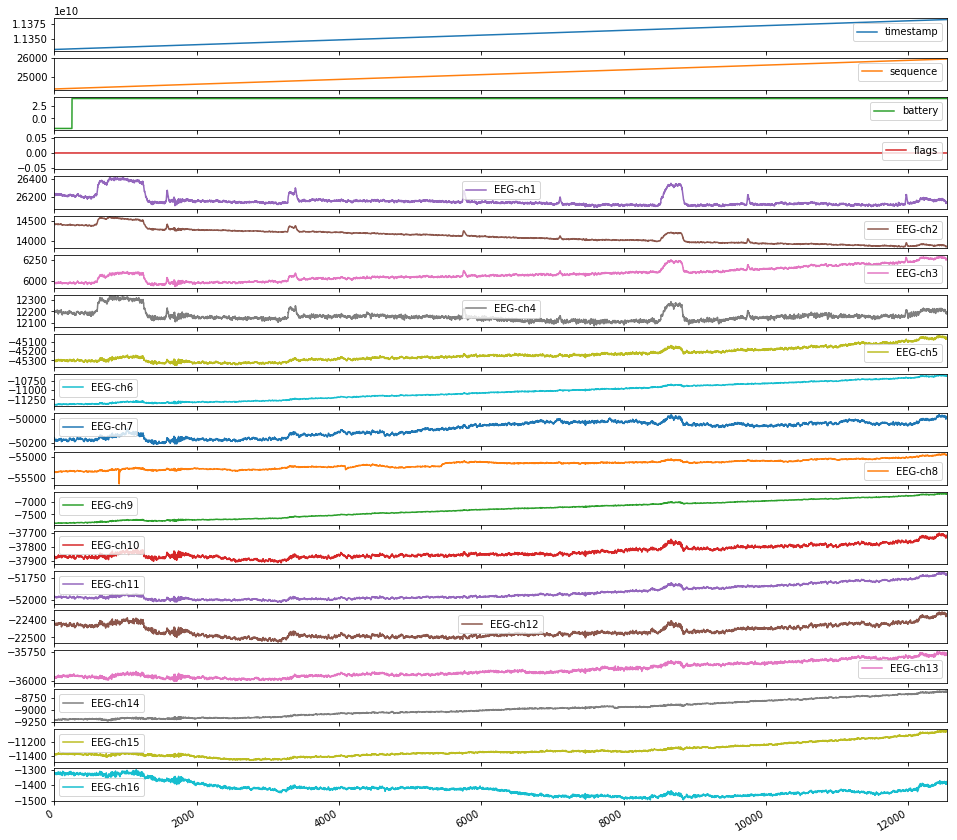

In [5]:
df.plot(subplots=True, figsize=(16, 16));

## From Pandas dataframe to MNE's `Raw` data structure

MNE uses a custom data structure, `Raw`, to hold EEG data.

`Raw` is composed of said EEG data plus certain `Info`, such as the number and name of the channels.

A handy class, `RawArray` is provided, which allows us to load `numpy` arrays into a MNE `Raw` structure.

In [84]:
df.columns

Index(['timestamp', 'sequence', 'battery', 'flags', 'EEG-ch1', 'EEG-ch2',
       'EEG-ch3', 'EEG-ch4', 'EEG-ch5', 'EEG-ch6', 'EEG-ch7', 'EEG-ch8',
       'EEG-ch9', 'EEG-ch10', 'EEG-ch11', 'EEG-ch12', 'EEG-ch13', 'EEG-ch14',
       'EEG-ch15', 'EEG-ch16'],
      dtype='object')

First, we remove non-EEG series from our data (like `timestamp` or `battery`).

In [45]:
df_mne = df.drop(['timestamp', 'sequence', 'battery', 'flags'], axis=1)

Then we convert the filtered dataframe into a Numpy array and transpose it (because MNE's `RawArray` takes a matrix where each row represents an EEG series, not a column like we had in our dataframe)

In [ ]:
data_mne = df_mne.to_numpy().transpose()

We then create the necessary `Info` object containing the name of each channel (which, as we later will see, has to be the name of the electrode position) and use it to create our `Raw` object

In [70]:
# Initialize an info structure
info_mne = mne.create_info(
    #ch_names=list(df_mne.columns),
    ch_names=['Fp1', 'Fp2', 'F3', 'F4', 'FC1', 'FC2', 'FC3', 'FC4', 'C1', 'C2', 'C3', 'C4', 'P7', 'O1', 'O2', 'P8'],
    ch_types='eeg',
    sfreq=256)

bbt_raw = mne.io.RawArray(data_mne, info_mne)
print(bbt_raw)

Creating RawArray with float64 data, n_channels=16, n_times=12544
    Range : 0 ... 12543 =      0.000 ...    48.996 secs
Ready.
<RawArray  |  None, n_channels x n_times : 16 x 12544 (49.0 sec), ~1.6 MB, data loaded>


MNE comes with some predefined `Montage`s out of the box. A `Montage` represents the 3D position of each electrode within a skull.

One of the predefined montages is a pretty standard 10-20 montage, containing position info about 94 possible electrode positions. Since we've named our electrodes following their position within a 10-20 system, MNE will automatically take their position out of this predefined montage.

In [85]:
ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')
print(ten_twenty_montage)

<DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 94 channels>


In [86]:
raw_1020 = bbt_raw.copy().set_montage(ten_twenty_montage)

DigMontage is a superset of info. 78 in DigMontage will be ignored. The ignored channels are: {'F8', 'O10', 'T8', 'PO1', 'Fpz', 'T7', 'TP7', 'CP1', 'TP9', 'P2', 'AF7', 'FT8', 'PO5', 'FT7', 'AF3', 'A2', 'AF9', 'Cz', 'C5', 'PO3', 'C6', 'PO6', 'P4', 'PO4', 'CP5', 'T10', 'CP4', 'PO8', 'M1', 'F5', 'T3', 'FCz', 'Iz', 'PO7', 'Fz', 'PO9', 'T6', 'AF4', 'AF6', 'P3', 'T9', 'AFz', 'F1', 'AF8', 'AF2', 'PO2', 'P9', 'T5', 'P5', 'PO10', 'FT10', 'F10', 'F7', 'POz', 'O9', 'FT9', 'CP6', 'FC5', 'CPz', 'TP10', 'P1', 'TP8', 'P6', 'CP3', 'M2', 'AF5', 'Pz', 'F9', 'T4', 'A1', 'AF1', 'AF10', 'CP2', 'P10', 'F2', 'Oz', 'F6', 'FC6'}


The data is now imported and we can proceed to do anything we would do with an MNE raw object.

## Plotting our imported MNE data

Effective window size : 8.000 (s)


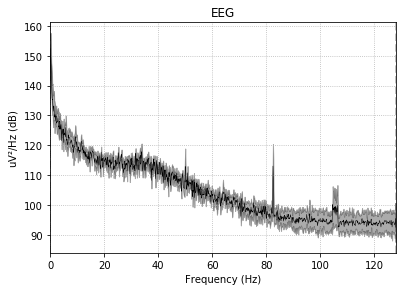

IndexError: index 1025 is out of bounds for axis 0 with size 1025

In [87]:
fig = bbt_raw.plot_psd(tmax=np.inf, fmax=250, average=True)
# add some arrows at 60 Hz and its harmonics:
for ax in fig.axes[:2]:
    freqs = ax.lines[-1].get_xdata()
    psds = ax.lines[-1].get_ydata()
    for freq in (60, 120, 180, 240):
        idx = np.searchsorted(freqs, freq)
        ax.arrow(x=freqs[idx], y=psds[idx] + 18, dx=0, dy=-12, color='red',
                 width=0.1, head_width=3, length_includes_head=True)

4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.


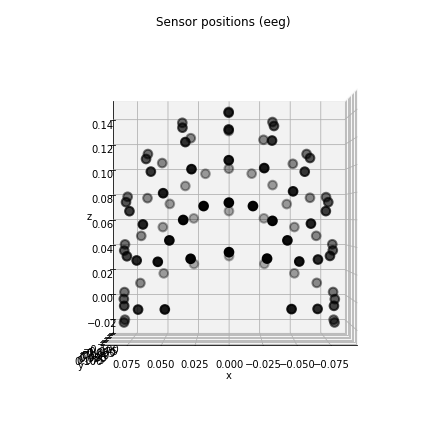

4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.


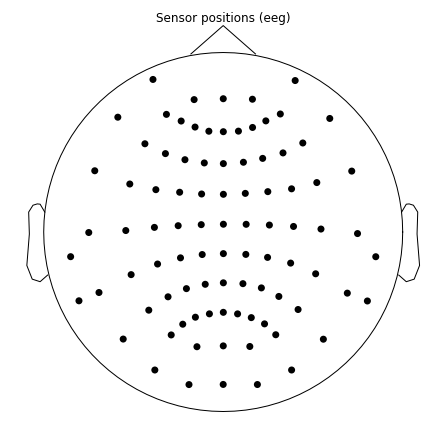

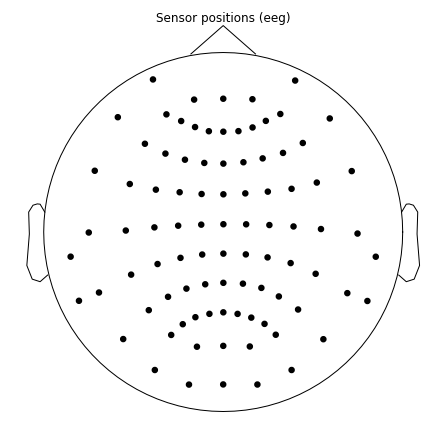

In [89]:
fig = ten_twenty_montage.plot(kind='3d')
fig.gca().view_init(azim=70, elev=15)
ten_twenty_montage.plot(kind='topomap', show_names=False)

// TODO: The ICA output is awful because we haven't set up the channel names correctly when building the Info object.
The dataset we've imported is one of the first datasets we've ever recorded and many electrodes were not actually in the position they have been assigned when buliding the Raw object. This is an error in our methodology, since we didn't keep track correctly of every electrode position. This will be solved in future datasets, which will be correctly doccumented.

Fitting ICA to data using 16 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 16 components
Fitting ICA took 0.2s.
    Using multitaper spectrum estimation with 7 DPSS windows
24 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
24 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


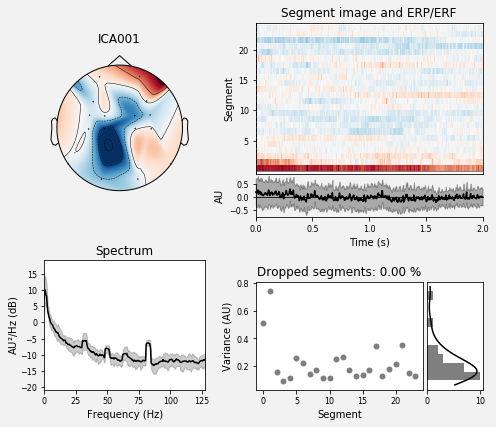

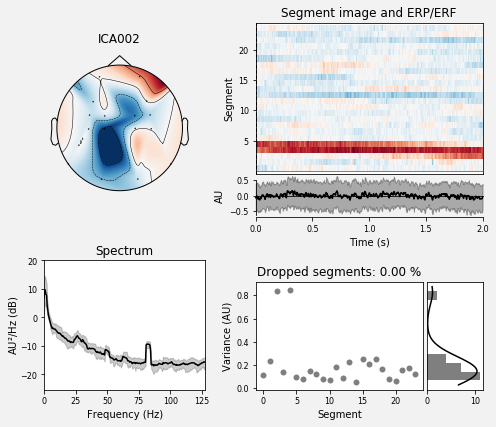

[<Figure size 504x432 with 6 Axes>, <Figure size 504x432 with 6 Axes>]

In [79]:
# set up and fit the ICA
ica = mne.preprocessing.ICA(n_components=16, random_state=97, max_iter=800)
ica.fit(raw_1020)
ica.exclude = [1, 2]  # details on how we picked these are omitted here
ica.plot_properties(raw_1020, picks=ica.exclude)